# CS 363D Final Project: Predicting Adoption in Austin Animal Center

## Mrityunjay Mishra, Rohit Neppalli, Ziyi Zhao, Justin Leong 

### Project Description

Many different types of animals (from dogs to livestock) are taken in by the Austin Animal Center each year for various reasons. Some may be adopted, some may be transferred, and some may even go through Euthanasia. The goal of this project is to predict if an animal, that is taken in by the Austin Animal Center, will be adopted or not. This can have good applications for Austin Animal Center - they could use our findings to predict the probability of adoption for an animal that is taken in and can care for it accordingly. Or perhaps someone else can use our findings to find animals who have a low probability of adoption to care for them accordingly. In the end, we hope that our findings provide insight into the adoption patterns of Austin and, consequently, helps different organizations take care of these animal appropriately.

In [90]:
# importing headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

### Dataset

To develop our classifier(s), we use the animal intake and outcome data from the open data portal of the city of Austin. To find our more about the animal intake data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm). To find out more about the outcome data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In [91]:
# Intakes data
intakes_df = pd.read_csv('Austin_Animal_Center_Intakes.csv')
intakes_df.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,January 2019,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,July 2015,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,April 2016,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Rio,06/29/2014 10:38:00 AM,June 2014,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


In [92]:
# Outcomes data
outcomes_df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
outcomes_df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


### Data Cleaning

We can immedietly see that we must combine both `intakes_df` and `outcomes_df` on `Animal ID`. We will first explore and clean both `intakes_df` and `outcomes_df` and combine them in the end.

`Name`, `DateTime`, `MonthYear`, and `Found Location` can immedietly be dropped from `intakes_df` because these features will not have be be relevant to determining if an animal will be adopted or not. The name of the pet animal could be changed after adoption; `DateTime` and `MonthYear` are related to `Age upon Intake` and thus irrelevant (because age is more important than the exact date etc.); and `Found Location` is also irrelevant in adoption matters. 

We may think that `Intake Type` can also be dropped. However, it actually has some useful values that may determine adoption or not. 

In [93]:
intakes_df['Intake Type'].unique()

array(['Stray', 'Owner Surrender', 'Public Assist', 'Wildlife',
       'Euthanasia Request', 'Abandoned'], dtype=object)

Clearly, if an animal is taken into Austin Animal Center on a Euthanasia Request, then its chances for being adopted become drastically low. Other reasons for intake can also play a part in adoption considerations. Therefore, then final columns that are dropped from `intakes_df` are `Name`, `DateTime`, `MonthYear`, `Found Location`.

In [94]:
intakes_df = intakes_df.drop(columns=['Name', 'DateTime', 'MonthYear', 'Found Location'])
intakes_df.head()

,Animal ID,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


Similarly, `Name`, `DateTime`, `Date of Birth`, and `Outcome Subtype` can immedietly be dropped from `outcomes_df` because there features will not be relevant to classification. Once again, `Name` is clearly irrelevant; the `DateTime` of the outcome makes no difference as to what the outcome is; the `Date of Birth` of the animal is related to its `Age upon Outcome` and thus is not important; and we are not interested in `Outcome Subtype` at the moment. We decided to keep `MonthYear` because it is possible that animals (or some types of animals) are adopted more at certain times of the year (e.x. Christmas) than others. `outcomes_ds` after removing these features is as follows.

In [95]:
outcomes_df = outcomes_df.drop(columns=['Name', 'DateTime', 'Date of Birth', 'Outcome Subtype'])
outcomes_df.head()

,Animal ID,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


As can be seen below, there are some values are missing from some rows in both `intakes_df` and `outcomes_df`. However, this is not a significant number of rows, so we just drop these rows. 

In [96]:
print('Total number of rows in intakes_df: {:d}\n'.format(intakes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in intakes_df')
print(intakes_df.count()) 

print('\nTotal number of rows in intakes_df: {:d}\n'.format(outcomes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in outcomes_df')
print(outcomes_df.count()) 

Total number of rows in intakes_df: 138350

Number of non-NaN rows (or rows without missing values in general) in intakes_df
Animal ID           138350
Intake Type         138350
Intake Condition    138350
Animal Type         138350
Sex upon Intake     138349
Age upon Intake     138350
Breed               138350
Color               138350
dtype: int64

Total number of rows in intakes_df: 138565

Number of non-NaN rows (or rows without missing values in general) in outcomes_df
Animal ID           138565
MonthYear           138565
Outcome Type        138542
Animal Type         138565
Sex upon Outcome    138564
Age upon Outcome    138559
Breed               138565
Color               138565
dtype: int64


In [97]:
intakes_df.dropna(inplace=True)
outcomes_df.dropna(inplace=True)

In [98]:
# Make a copy of the cleaned, original dataset for future use
intakes_original = intakes_df.copy()
outcomes_original = outcomes_df.copy()

### Data Exploration and Feature Engineering

We can see that most of the features are categorical data. Specifically, `Intake Type`, `Intake Condition`, `Animal Type`, `Sex upon Intake`, `Breed`, and `Color` are categorical features in `intakes_df`. Similarly, `Outcome Type`, `Animal Type`, `Sex upon Outcome`, `Breed`, and `Color` are all categorial features in `outcomes_df`. We change these feature values from string to labels using `pd.factorize` for ease of use with our classifiers later.

In [99]:
# Assigning labels for intakes_df
categorical_features = ['Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Breed', 'Color']
intakes_df[categorical_features] = intakes_df[categorical_features].apply(lambda x: pd.factorize(x)[0])

# Assigning labels for outcomes_df
categorical_features = ['Outcome Type', 'Animal Type', 'Sex upon Outcome', 'Breed', 'Color']
outcomes_df[categorical_features] = outcomes_df[categorical_features].apply(lambda x: pd.factorize(x)[0])

We can also see that `Age upon Intake` and `Age upon Outcome` features in `intakes_df` and `outcomes_df` is currently a string. We cast this to a number for better use with our classifiers. 

In [100]:
def standardize_age(age):
  if 'month' in age:
    return 0
  if 'year' in age:
    return int(age.split(' ')[0])
  if 'day' in age:
    return 0
  return 0

intakes_df['Intake Age (Years)'] = intakes_df['Age upon Intake'].apply(lambda x: standardize_age(x))
intakes_df = intakes_df.drop(columns=['Age upon Intake'])

outcomes_df['Outcome Age (Years)'] = outcomes_df['Age upon Outcome'].apply(lambda x: standardize_age(x))
outcomes_df['Outcome Month'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[0])
outcomes_df['Outcome Month'] = outcomes_df['Outcome Month'].map(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(x) + 1)
outcomes_df['Outcome Year'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[1])
outcomes_df = outcomes_df.drop(columns=['Age upon Outcome', 'MonthYear'])

In [101]:
intakes_df.head()

,Animal ID,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Intake Age (Years)
0,A786884,0,0,0,0,0,0,2
1,A706918,0,0,0,1,1,1,8
2,A724273,0,0,0,2,2,2,0
3,A665644,0,1,1,3,3,3,0
4,A682524,0,0,0,0,4,4,4


In [102]:
outcomes_df.head()

,Animal ID,Outcome Type,Animal Type,Sex upon Outcome,Breed,Color,Outcome Age (Years),Outcome Month,Outcome Year
0,A794011,0,0,0,0,0,2,5,2019
1,A776359,1,1,0,1,1,1,7,2018
2,A821648,2,2,1,2,2,1,8,2020
3,A720371,1,1,0,3,3,0,2,2016
4,A674754,3,0,2,0,4,0,3,2014


Now that appropriate pre-processing has been done on both `intakes_df` and `outcomes_df`, we can combine both `intakes_df` and `outcomes_df` on `Animal ID` to get our final dataset. We will drop `Animal ID` because after this point it will not be useful to us for the task of classfication.

In [103]:
# Combine together into singular dataframe
data = intakes_df.merge(outcomes_df[['Animal ID', 'Outcome Type', 'Sex upon Outcome', 'Outcome Age (Years)', 'Outcome Month', 'Outcome Year']], on='Animal ID')
data = data.drop('Animal ID', axis=1)
data.head()

,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Intake Age (Years),Outcome Type,Sex upon Outcome,Outcome Age (Years),Outcome Month,Outcome Year
0,0,0,0,0,0,0,2,3,0,2,1,2019
1,0,0,0,1,1,1,8,4,3,8,7,2015
2,0,0,0,2,2,2,0,4,0,1,4,2016
3,0,1,1,3,3,3,0,3,4,0,10,2013
4,0,0,0,0,4,4,4,4,0,4,7,2014


Now, let's plot a histogram of each feature to check the distribution of its values

In [115]:
intakes_original['Intake Type'].unique()

array(['Stray', 'Owner Surrender', 'Public Assist', 'Wildlife',
       'Euthanasia Request', 'Abandoned'], dtype=object)

In [116]:
intakes_original.head()

,Animal ID,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


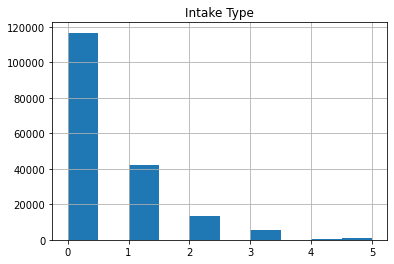

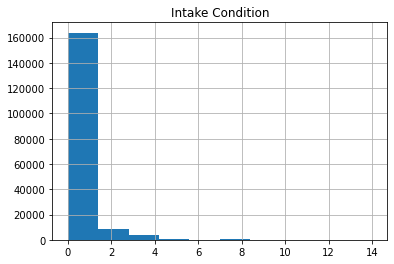

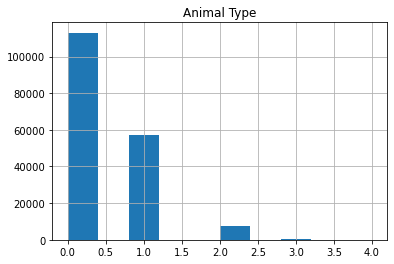

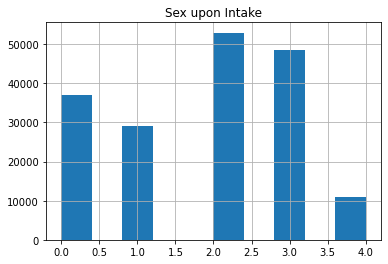

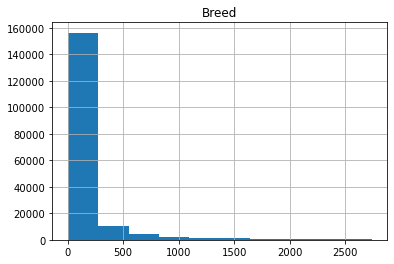

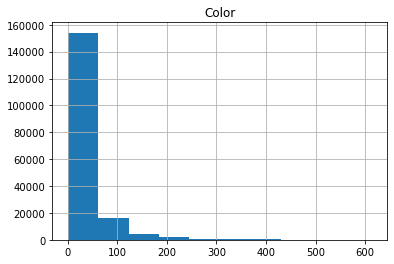

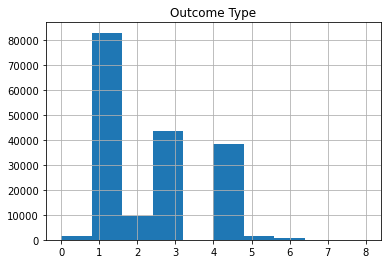

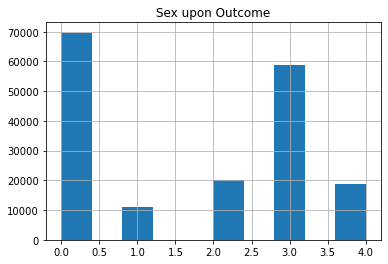

In [111]:
# Plot a histogram of each feature value for all features
# that are categorical features. Note that the x-axis of 
# these histograms is a number, which represents a specific
# label for that feature.
for column in data.columns:
    check = (column == 'Intake Age (Years)' or column == 'Outcome Age (Years)' \
                        or column == 'Outcome Month' or column == 'Outcome Year')
    if check: continue # skip these columns since they are continuous features
    
    data.hist(column=column)

In [117]:
data['Animal Type'].unique()

array([0, 1, 2, 3, 4])

From the histograms above, we see that not all data is distributed equally. For instance, there are significantly more `Intake Type` with a label of 0 than with a label of 5. A similar trend can be seen for other features as well. As a result, we must sample the data in order to have an equal (or as close to equal as possible) distribution of values per feautre.

### SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

scaler = StandardScaler()
pca = PCA()
svc = SVC()

features = data.drop('Outcome Type', axis=1)
labels = data['Outcome Type']

pipeline = Pipeline(steps=[('scaling', scaler), ('pca', pca), ('svc', svc)])
param_grid = {
    'pca__n_components': list(range(10, 11)),
    'svc__kernel': ['linear']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

predictions = cross_val_predict(grid_search, features, labels, cv=5)

print(accuracy_score(labels, predictions))
print(classification_report(labels, predictions))

## Decision Trees Nested Cross Validation

In [8]:
# Try out some classification approaches, with outcome type as the label
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy')
grid_params = {
    'max_depth': [5, 8, 13], 
    'min_samples_leaf': [5, 10, 15, 20], 
    'max_features': [5, 8, 13]
}
grid_search = GridSearchCV(decision_tree, grid_params, cv=5, scoring='accuracy')
grid_search.fit(combined_df.drop('Outcome Type', axis=1), combined_df['Outcome Type'])
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 13, 'max_features': 13, 'min_samples_leaf': 20}
0.718860950887607


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(grid_search, combined_df.drop('Outcome Type', axis=1), combined_df['Outcome Type'])
print(confusion_matrix(combined_df['Outcome Type'], predictions))

[[    0     0    15     4     3    11     0     1     0     0]
 [    0    13   970     4    66   589     1     0     0     0]
 [    0    39 70761   139  3469  8607     2     5     0     0]
 [    0     0   854  5995  1726   856     7    45     0     0]
 [    0     5 12539   705 24456  6063    12    15     0     0]
 [    0    13  7747   211  3438 27081     1     2     0     0]
 [    0     1   170   260   803    89     9     8     0     0]
 [    0     0    15   454    95    20     0    53     0     0]
 [    0     0    23     2    35    39     0     0     0     0]
 [    0     0     7    14     2     1     0     0     0     0]]


In [10]:
combined_df['Outcome Type'].value_counts()

 1    83022
 3    43795
 4    38493
 2     9483
 0     1643
 5     1340
 6      637
 7       99
-1       34
 8       24
Name: Outcome Type, dtype: int64